In [1]:
!pip install peft
!pip install accelerate
!pip install bitsandBytes
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=0c5d2732300bd578bcff0a66ee0380ded441f1204d75ca4dacb715031930caa7
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [3]:
import torch
import GPUtil
import os

GPUtil.showUtilization()

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available, using CPU instead")

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU is available


In [4]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, LlamaTokenizer
from huggingface_hub import notebook_login
from datasets import load_dataset
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

if "COLAB_GPU" in os.environ:
  from google.colab import output
  output.enable_custom_widget_manager()

In [5]:
if "COLAB_GPU" in os.environ:
  !huggingface-cli login
else:
  notebook_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `finetuning` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `finetun

In [6]:
base_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [7]:
!git clone https://github.com/poloclub/Fine-tuning-LLMs.git

Cloning into 'Fine-tuning-LLMs'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 47 (delta 14), reused 29 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 9.34 MiB | 36.22 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [9]:
import os

file1 = "/content/Fine-tuning-LLMs/data/hawaii_wf_1.txt"
print(os.access(file1, os.R_OK))

True


In [10]:
from datasets import Dataset

texts = []
file_paths = [
    "/content/Fine-tuning-LLMs/data/hawaii_wf_1.txt",
    "/content/Fine-tuning-LLMs/data/hawaii_wf_4.txt"
]

for path in file_paths:
    with open(path, "r") as f:
        texts.append(f.read())

train_dataset = Dataset.from_dict({"text": texts})
print(train_dataset)  # Should show num_rows: 2

Dataset({
    features: ['text'],
    num_rows: 2
})


In [11]:
# train_dataset = load_dataset("text", data_files={"train":
#                                                   ["/content/Fine-tuning-LLMs/data/hawaii_wf_1.txt", "/content/Fine-tuning-LLMs/data/hawaii_wf_4.txt"]}, split="train")

In [12]:
from datasets import Dataset

def read_first_lines(file_paths):
    first_lines = []
    for path in file_paths:
        with open(path, 'r') as f:
            first_lines.append(f.readline().strip())  # Read just the first line
    return {"text": first_lines}

file_paths = [
    "/content/Fine-tuning-LLMs/data/hawaii_wf_1.txt",
    "/content/Fine-tuning-LLMs/data/hawaii_wf_4.txt"
]

train_dataset = Dataset.from_dict(read_first_lines(file_paths))
print(train_dataset["text"][1])  # Now directly gives first line

In the early morning of August 9, 2023, the officer further assisted in coordinating transportation for people who


In [13]:
train_dataset["text"][1]

'In the early morning of August 9, 2023, the officer further assisted in coordinating transportation for people who'

In [14]:
tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False, trust_remote_code=True, add_eos_token=True)

if tokenizer.pad_token is None:
  tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [15]:
tokenized_train_dataset = []
for phrase in train_dataset:
  tokenized_train_dataset.append(tokenizer(phrase["text"]))

In [16]:
tokenized_train_dataset[0]

{'input_ids': [1, 349, 5607, 12107, 5012, 26092, 13780, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
tokenized_train_dataset[1]

{'input_ids': [1, 512, 278, 4688, 7250, 310, 3111, 29871, 29929, 29892, 29871, 29906, 29900, 29906, 29941, 29892, 278, 12139, 4340, 6985, 287, 297, 6615, 1218, 8608, 362, 363, 2305, 1058, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
tokenizer.eos_token

'</s>'

In [19]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=8,
    lora_alpha=64,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

In [20]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    args=transformers.TrainingArguments(
        output_dir="./finetunedModel",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=2,
        num_train_epochs=3,
        learning_rate=1e-4,
        max_steps=20,
        bf16=False,
        optim="paged_adamw_8bit",
        logging_dir="./log",
        save_strategy="epoch",
        save_steps=50,
        logging_steps=10

),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache=False
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vjc5505 (vjc5505-university-of-north-texas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,1.258500
20,0.113300


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

TrainOutput(global_step=20, training_loss=0.6858827471733093, metrics={'train_runtime': 269.0692, 'train_samples_per_second': 0.297, 'train_steps_per_second': 0.074, 'total_flos': 47716791091200.0, 'train_loss': 0.6858827471733093, 'epoch': 20.0})

In [21]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig, LlamaTokenizer
from peft import PeftModel

base_model_id = "meta-llama/Llama-2-7b-chat-hf"

nf4Config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False, trust_remote_code=True, add_eos_token=True)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=nf4Config,
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
  )


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False, trust_remote_code=True, add_eos_token=True

                              )

modelFinetuned = PeftModel.from_pretrained(base_model, "finetunedModel/checkpoint-20")

In [24]:
user_question = "When did Hawaii wildfires start?"

eval_prompt = f"Question: {user_question} Just answer this question accurately and concisely.\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()

with torch.no_grad():
  print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens=1024)[0], skip_special_tokens=True))
  torch.cuda.empty_cache()

Question: When did Hawaii wildfires start? Just answer this question accurately and concisely.
s. The wildfires in Hawaii started on August 9, 2023, according to the Hawaii Department of Forestry and Wildlife.

Note: The information provided is accurate as of the current date and time, but it is possible that the situation may change rapidly and new information may become available.


In [25]:
# First question (wildfires)
user_question1 = "When did Hawaii wildfires start?"
eval_prompt1 = f"Question: {user_question1} Just answer this question accurately and concisely.\n"

# Second question (any other topic)
user_question2 = "How many acres were burned in the Lahaina fire?"
eval_prompt2 = f"Question: {user_question2} Just answer this question accurately and concisely.\n"

# Process both questions
for question in [eval_prompt1, eval_prompt2]:
    promptTokenized = tokenizer(question, return_tensors="pt").to("cuda")
    modelFinetuned.eval()
    with torch.no_grad():
        print(tokenizer.decode(
            modelFinetuned.generate(**promptTokenized, max_new_tokens=1024)[0],
            skip_special_tokens=True
        ))
    torch.cuda.empty_cache()

Question: When did Hawaii wildfires start? Just answer this question accurately and concisely.
sources:
-https://www.fire.state.hi.us/wildland-fire-management/wildfire-history-in-hawaii/
-https://www.hawaiicounty.gov/departments/fire-department/fire-history
-https://www.kitsapsun.com/news/local-news/hawaii-wildfires-burn-acres-and-homes-in-2023/

Hawaii wildfires have been occurring for decades, with the first recorded wildfire in the state happening in 1899. Since then, there have been numerous wildfires throughout the islands, with some of the most significant occurring in recent years.

According to the Hawaii Fire Department, in 2023, there were over 1,000 wildfires that burned over 10,000 acres of land and destroyed multiple homes. The causes of these wildfires varied, including human-caused incidents such as arson and unattended campfires, as well as natural causes such as lightning strikes and strong winds.

To help prevent wildfires in the future, the state of Hawaii has implem

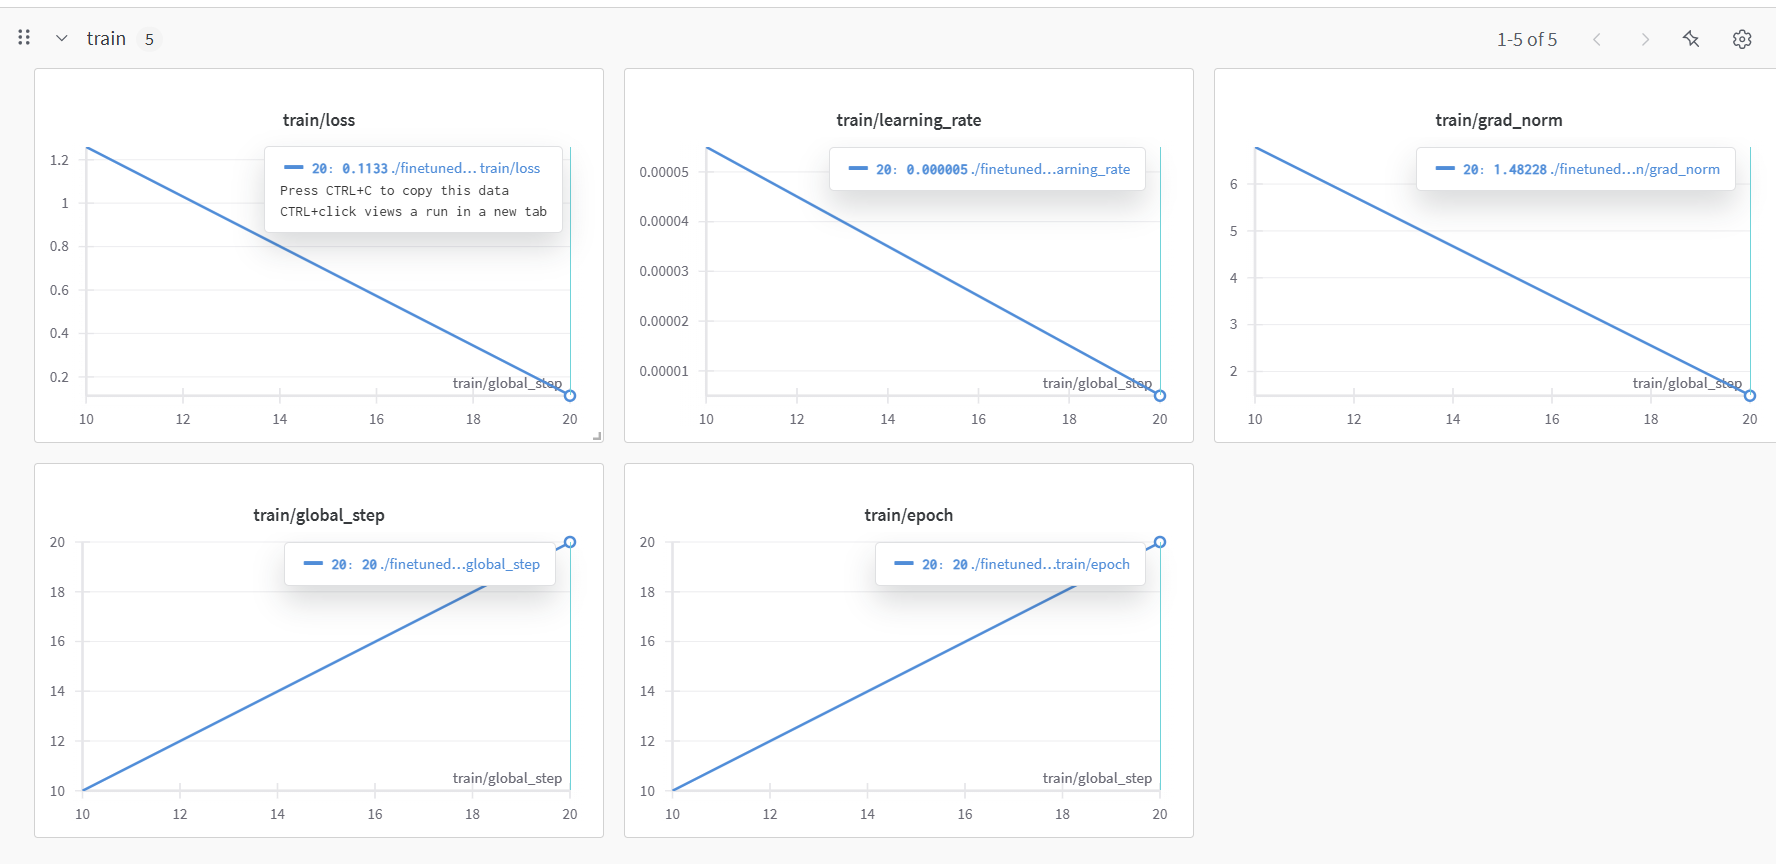